In [21]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

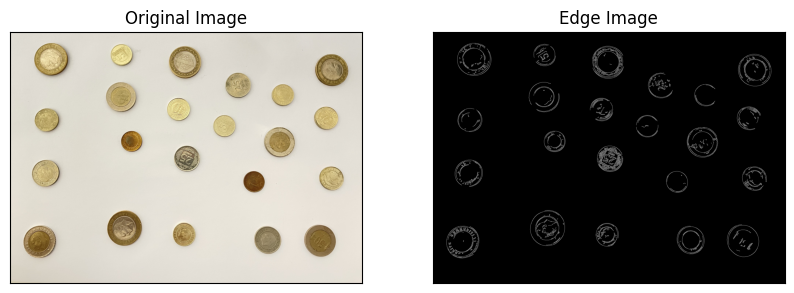

In [22]:
# Load the image
image_path = 'TestR\\01.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Resize the image to half of its original size for faster processing
resized_image = cv2.resize(gray_image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

# Apply Gaussian Blur to smoothen the image
blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)

# Apply Canny Edge Detector
edges = cv2.Canny(blurred_image, 100, 200)

# Display the original image and the edge-detected image using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(121), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

# Show the matplotlib plot
plt.show()

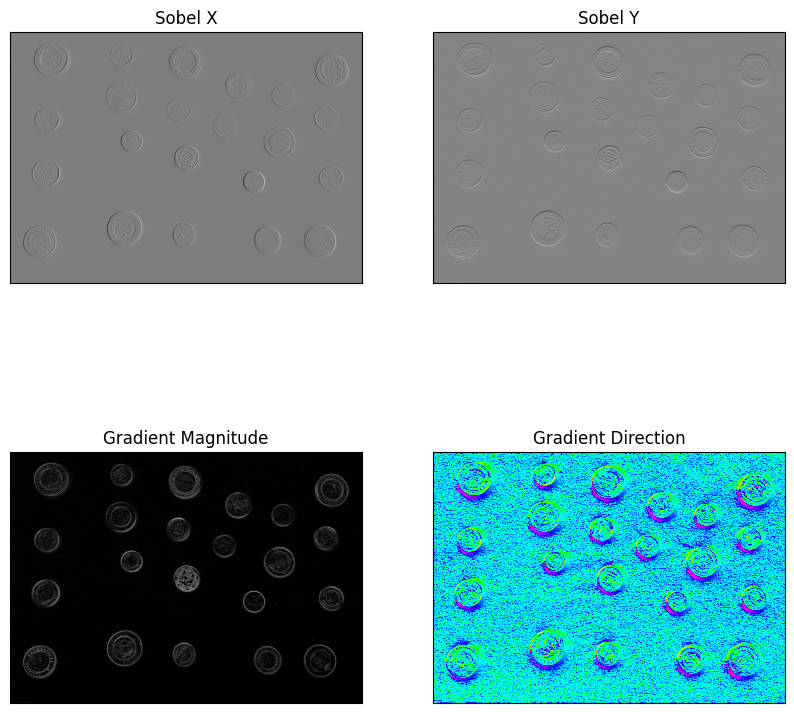

In [23]:
# Apply Sobel operator to find the gradients
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

# Calculate the gradient magnitude and direction
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
direction = np.arctan2(sobel_y, sobel_x)

# Normalize the magnitude to be in the range [0, 255] for display purposes
magnitude = np.uint8(255 * magnitude / np.max(magnitude))

# Display the gradient magnitude and direction
plt.figure(figsize=(10, 10))

plt.subplot(221), plt.imshow(sobel_x, cmap='gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])

plt.subplot(222), plt.imshow(sobel_y, cmap='gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude'), plt.xticks([]), plt.yticks([])

plt.subplot(224), plt.imshow(direction, cmap='hsv') # HSV color map to show direction
plt.title('Gradient Direction'), plt.xticks([]), plt.yticks([])

# Show the matplotlib plot
plt.show()


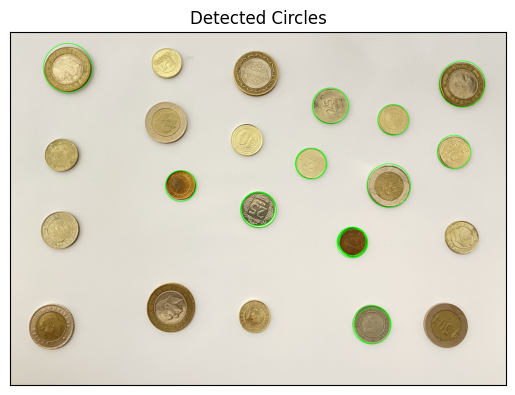

In [24]:
import math

# Define the Hough Transform function for circles
def hough_circle_transform(edge_image, magnitude, direction, radius_range):
    # Initialize the Hough accumulator array to zeros
    # The dimensions are based on the image size and the range of radii
    hough_space = np.zeros((edge_image.shape[0], edge_image.shape[1], len(radius_range)))

    # Cast votes in the Hough space
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            # Check if we have an edge point
            if edge_image[y, x] > 0:
                # Cast votes for potential circle centers
                for radius_index, radius in enumerate(radius_range):
                    # Determine the a and b offsets based on the gradient direction
                    a = int(x - radius * math.cos(direction[y, x]))
                    b = int(y - radius * math.sin(direction[y, x]))
                    # Check if the center would be within bounds
                    if a >= 0 and a < edge_image.shape[1] and b >= 0 and b < edge_image.shape[0]:
                        hough_space[b, a, radius_index] += 1

    return hough_space

# Define a range of radii to search for circles
# Since we resized the image to half its original size, the radii should be adjusted accordingly
radius_range = np.arange(10, 100, 5)

# Apply the Hough Transform for circle detection
hough_space = hough_circle_transform(edges, magnitude, direction, radius_range)

# Find the peaks in the Hough space to identify the circles
# We use a simplistic approach to find peaks by applying a threshold
threshold = 0.6 * hough_space.max()
circles = np.where(hough_space >= threshold)

# Extract the circle parameters
detected_circles = []
for idx in range(len(circles[0])):
    b, a, radius_index = circles[0][idx], circles[1][idx], circles[2][idx]
    radius = radius_range[radius_index]
    detected_circles.append((a, b, radius))

# Display the circles on the original image
output_image = original_image.copy()
for circle in detected_circles:
    a, b, radius = circle
    # Scale up the circle parameters to match the original image size
    a, b, radius = a * 2, b * 2, radius * 2
    cv2.circle(output_image, (a, b), radius, (0, 255, 0), 4)

# Display the original image with detected circles
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.xticks([]), plt.yticks([])
plt.show()
